<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

`1.` Загружаем датасет и выводим 5 случайных строк из него.

In [3]:
data = pd.read_csv('./train.csv')
data.sample(5, random_state = 42).sort_index()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
240,25,20.95,495.15,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0
1448,9,45.40,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
3964,44,100.10,4378.35,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
4792,37,70.35,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0


In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

`2.` Смотрим, есть ли в датасете незаполненные значения или неверные, и строим таблицу (имя колонки, кол-во плохих строк. Делаем вывод, что в столбце TotalSpent 9 строк не в порядке.

In [5]:
print(((data == ' ') | (data == '') | data.isna()).sum())

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


Так как пустых/неверных строк всего 9 строк из 5282, их можно просто удалить.

In [6]:
data = data.loc[data['TotalSpent'] != ' ']
data = data.loc[data['TotalSpent'] != '']
data = data.loc[data['TotalSpent'].notna()]

In [7]:
# преобразуем всё в единый формат, тк TotalSpent содержит значения и в виде чисел и в виде строк
totalSpent = np.array([])
for el in np.array(data['TotalSpent']):
    totalSpent = np.append(totalSpent, float(el))
data.TotalSpent = totalSpent

Смотрим, остались ли в датасете незаполненные значения, после строим таблицу (колонка - кол-во nan'ов). 
Убеждаемся, что теперь все данные в порядке.

In [8]:
print(((data == ' ') | (data == '') | data.isna()).sum())

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

`1.1.` Для численных призанков построим гистограммы.


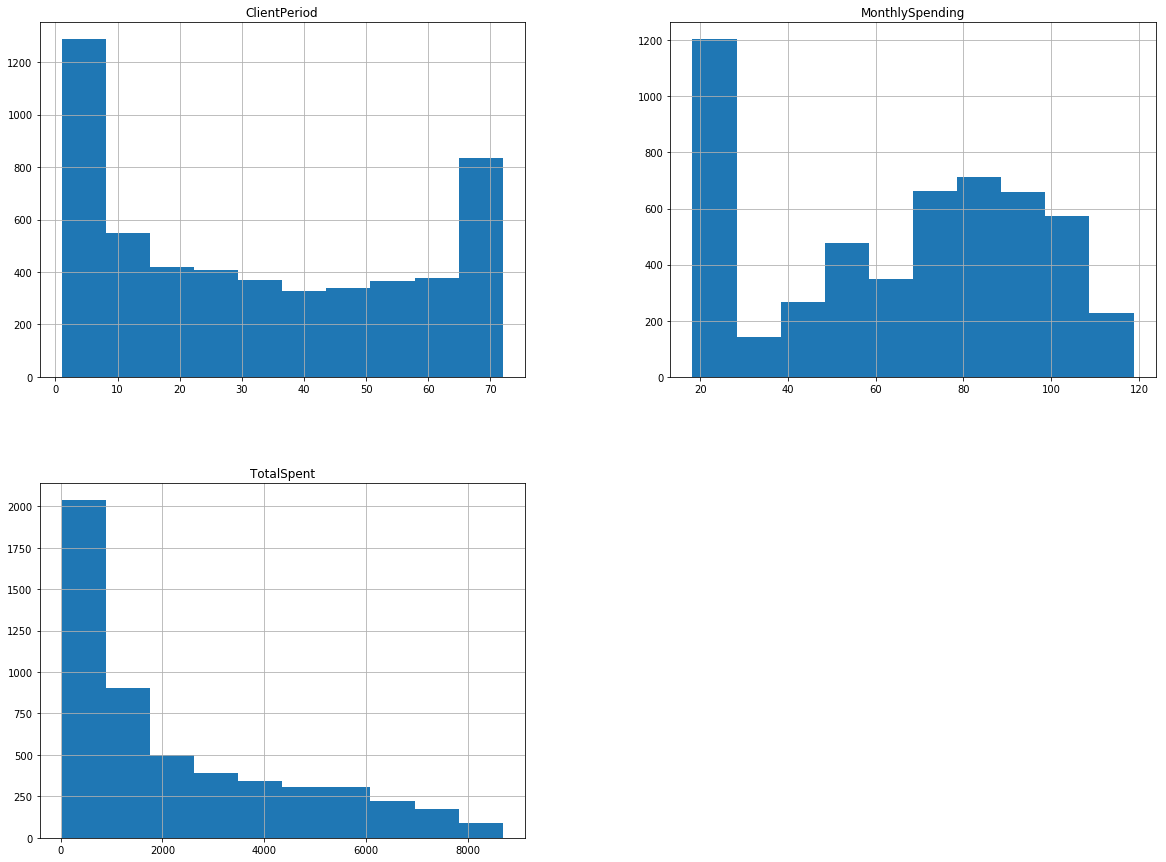

In [9]:
#fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15,5), );
#axs[0].hist(data.ClientPeriod, histtype = 'step', color = 'red')
#axs[0].set_title('ClientPeriod', fontfamily = 'fantasy', fontstyle = 'oblique', fontsize = 30, color = 'red')
#axs[1].hist(data.MonthlySpending, histtype = 'step', label = 'MonthlySpending')
#axs[1].set_title('MonthlySpending', fontfamily = 'fantasy', fontstyle = 'oblique', fontsize = 30, color = 'blue')
#axs[2].hist(data.TotalSpent, histtype = 'step', color = 'green', label = 'TotalSpent')
#axs[2].set_title('TotalSpent', fontfamily = 'fantasy', fontstyle = 'oblique', fontsize = 30, color = 'green')

data.hist(column=num_cols, figsize=(20, 15))
None

`1.2.` Посмотрим кол-во каждого значения для каждого категориального признака и построим круговые диаграммы.


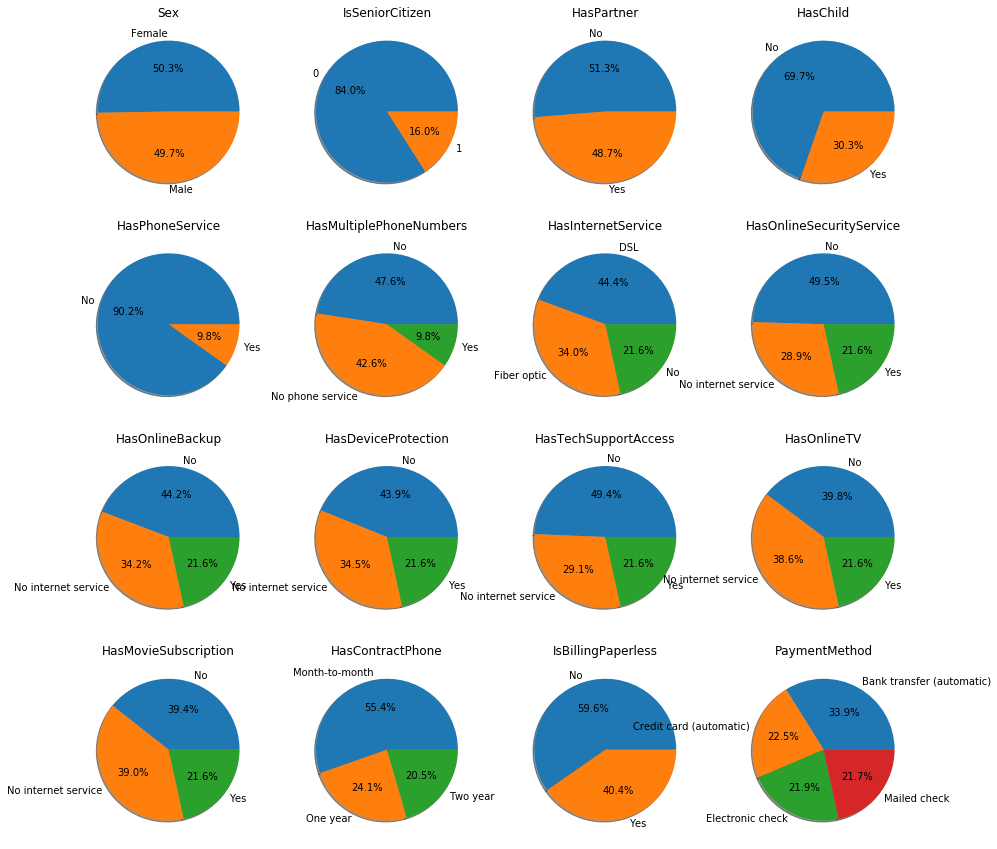

In [10]:
#for el in cat_cols:
#    print(f'\033[1;32m {el}')
#    print(f'\033[1;33m{data[el].value_counts()}') 
#    plt.pie(data[el].value_counts(), labels = data[el].value_counts().index)
#    plt.show()
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i, col in enumerate(cat_cols):
    axes[i // 4][i % 4].tick_params(axis='x', rotation=15)
    axes[i // 4][i % 4].set_title(col)
    labels = np.unique(data[col], return_counts=True)[0]
    axes[i // 4][i % 4].pie(data[col].value_counts(), labels=labels, shadow=True, autopct='%1.1f%%')

`2.` Посмотрим на распределение целевой переменной.

 Churn
0    3889
1    1384
Name: Churn, dtype: int64


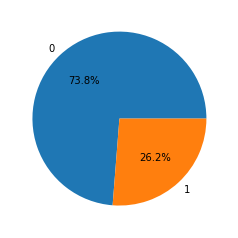

In [11]:
el = 'Churn'
print(f'\033[1;32m {el}')
print(f'\033[1;33m{data[el].value_counts()}') 
plt.pie(data[el].value_counts(), labels = data[el].value_counts().index, autopct='%1.1f%%')
plt.show()

Как видно по вычислениям выше, класс `0` в 3 раза больше `1`, поэтому можно сделать вывод, что классы впринципе сбалансированы.

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

`Дополнительно:` в ячейках выше было убрано 9 ошибок в столбце TotalSpent, затем весь столбец преобразован в единый формат `float`.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

`1.1.` При помощи one-hot-encoding закодируем категориальные признаки, затем соберём все признаки в одну переменную.

In [13]:
numeric_data = data[num_cols]
categorial_data = data[cat_cols]
dummy_features = pd.get_dummies(categorial_data)
X = pd.concat([numeric_data, dummy_features], axis=1)#, df[tar]
X_origin = data.iloc[:, :-1]
y = data[target_col]

`2.1.`Разобьем датасет на тренировочную и тестовую части

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.7,
                                                    random_state=36)

`2.2.` С помощью кроссвалидации отнормируем признаки и протестируем разные значения гиперпараметра C и выберем лучший (С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. нормализация объединена с моделью логистической регрессии в пайпдайн.

In [15]:
params = {
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


model_grid = GridSearchCV(make_pipeline(StandardScaler(), LogisticRegression()),
                    param_grid=params, scoring='roc_auc', n_jobs=-1,
                    cv=10,
                    refit=True)
model_grid.fit(X_train, y_train)
pred1 = model_grid.predict_proba(X_train)[:, 1]
pred2 = model_grid.predict_proba(X_test)[:, 1]
print(model_grid.best_params_)

{'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


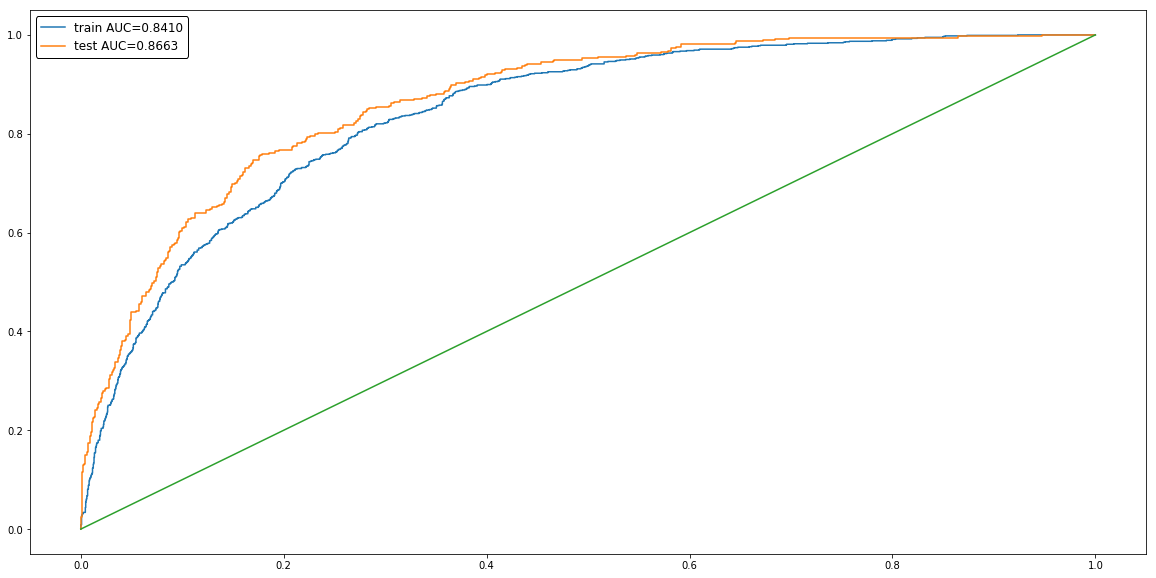

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, pred1)
test_auc = roc_auc_score(y_test, pred2)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, pred1)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, pred2)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Наибольшее значение ROC-AUC = `0.8663` при комбинации `'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'`

In [17]:
print(f"\033[1;32mbest C = ",model_grid.best_params_['logisticregression__C'])

best C =  1


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

`1` Разделим выборку на train/valid. Протестируем catboost cо стандартными параметрами.

In [18]:
from catboost import CatBoostClassifier # документация: https://catboost.ai/docs

In [19]:
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values, 
                                                       train_size=0.7,
                                                       random_state=36)

In [20]:
boosting_model_default = CatBoostClassifier(cat_features=np.arange(3, 19), verbose=False)

boosting_model_default.fit(X_train_origin, y_train)

y_train_predicted = boosting_model_default.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model_default.predict_proba(X_test_origin)[:, 1]

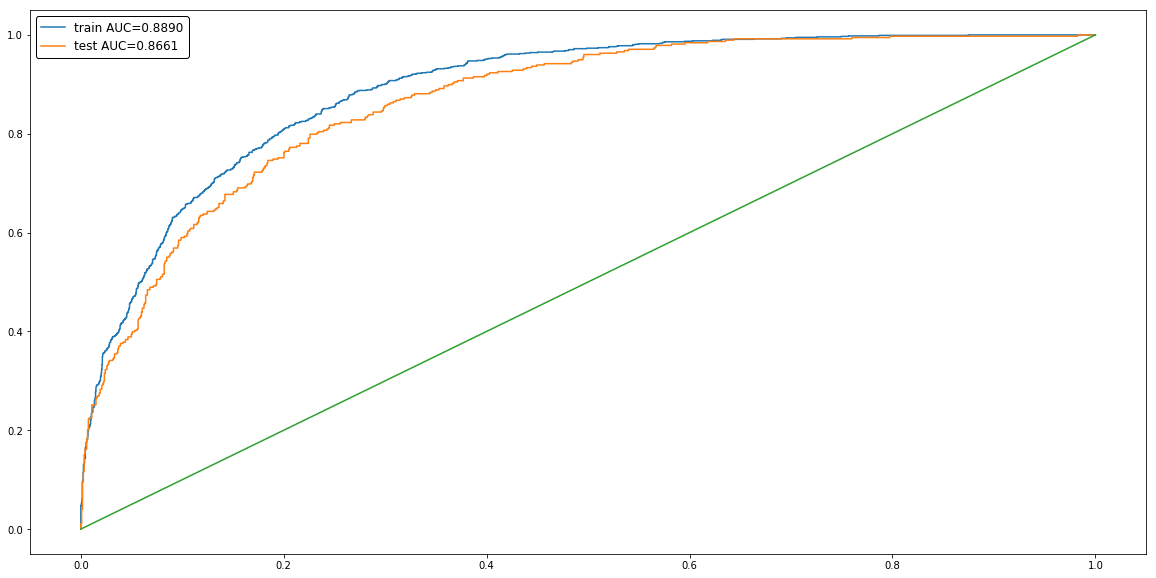

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

`2` Протестировав разные занчения параметроа количества деревьев и learning_rate'а, мы выбрали  лучшую по метрике ROC-AUC комбинацию.

In [22]:
boosting_model = CatBoostClassifier(cat_features=np.arange(3, 19), n_estimators=200, learning_rate = 0.08, #09 22
                                    depth = 5, eval_metric = 'AUC', leaf_estimation_method = 'Gradient', 
                                    loss_function = 'CrossEntropy', verbose=False)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

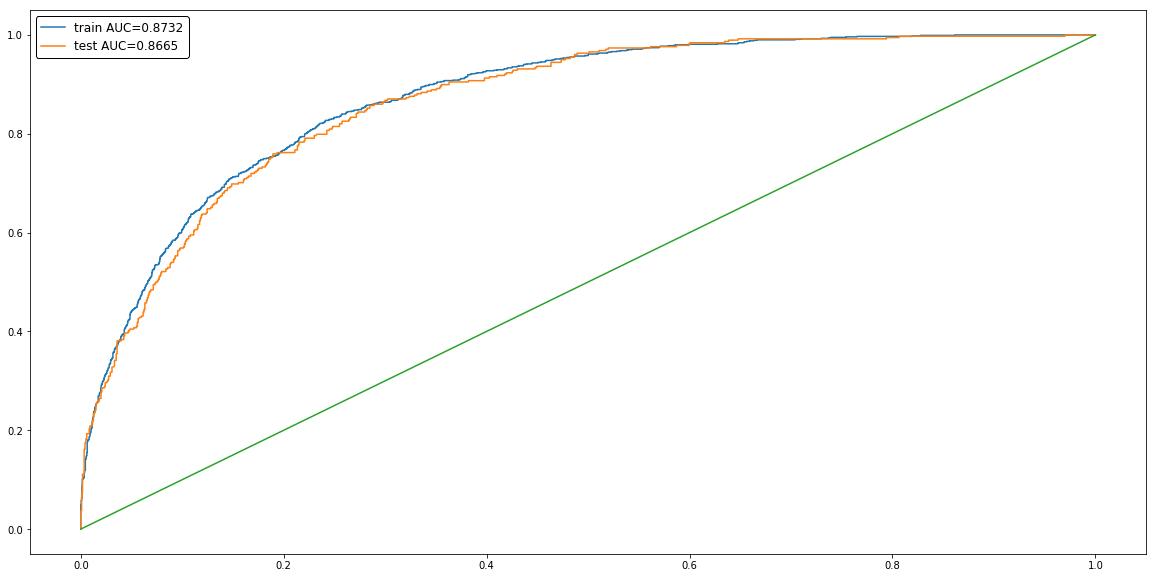

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Наибольшее значение ROC-AUC = `0.8665` при комбинации `n_estimators=200, learning_rate = 0.08, depth = 5, eval_metric = 'AUC', leaf_estimation_method = 'Gradient', loss_function = 'CrossEntropy'`

# Предсказания

In [24]:
best_model = boosting_model# какая-то предыдущая модель

In [25]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = 1 - best_model.predict_proba(X_test)# best_model.predict_proba(X_test) / best_model.predict(X_test)
submission.to_csv('./my_submission.csv', index = False)

# Kaggle (5 баллов)

Как выставить баллы:

<font color='green'><strong>1) 1 >= 0.85276 > 0.84 это 5 баллов</strong></font>

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.

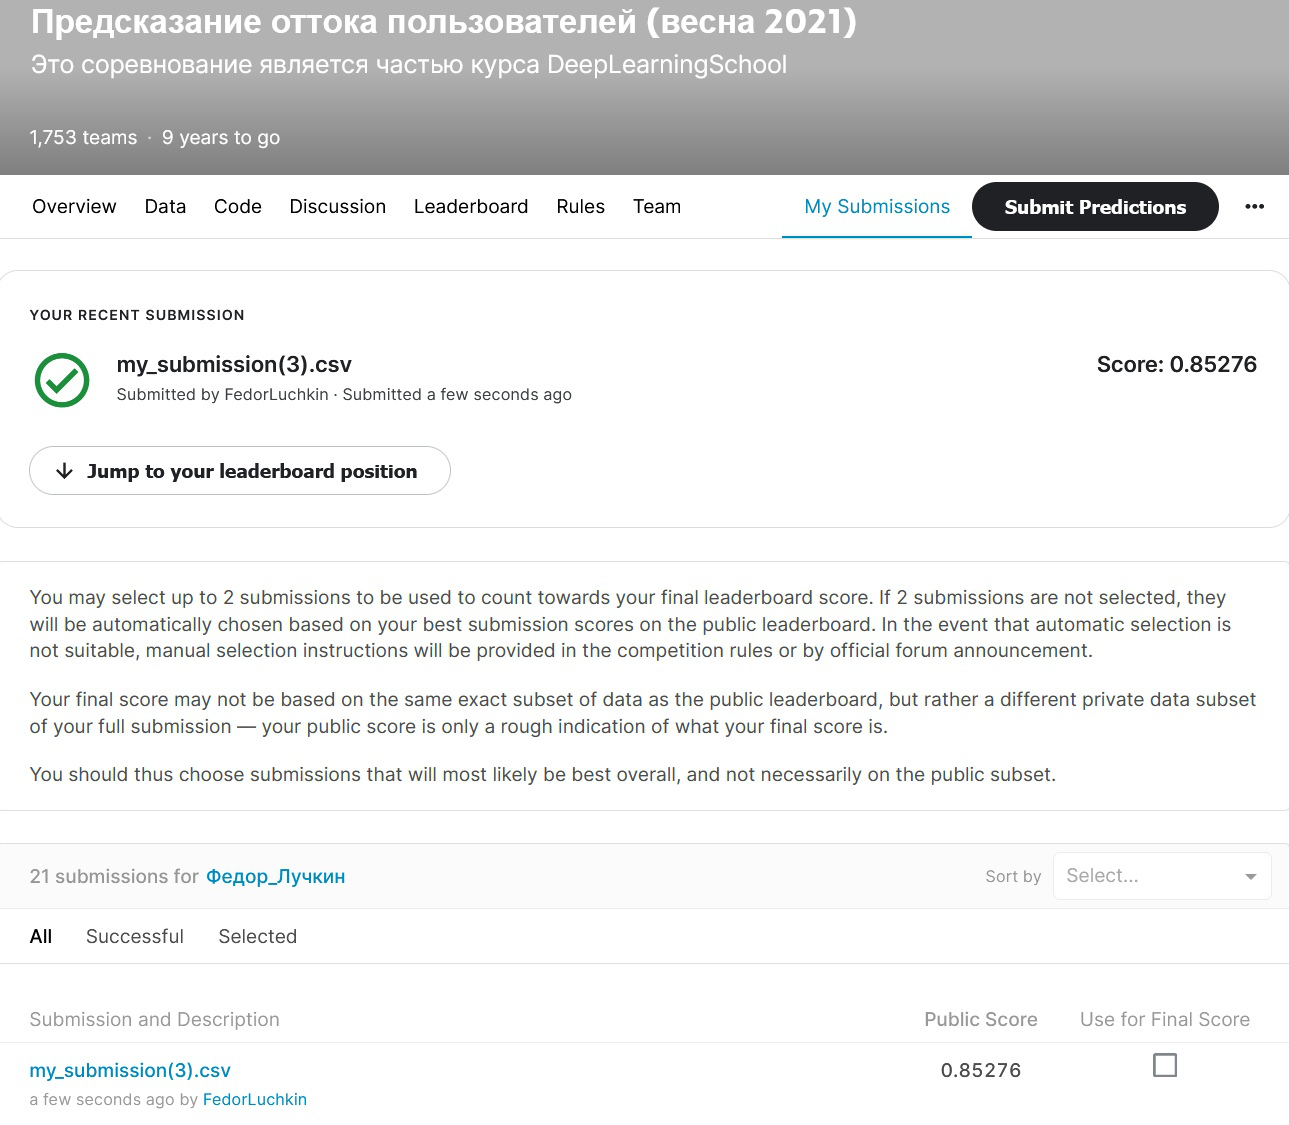

In [26]:
from PIL import Image
from urllib.request import urlopen
url = "https://sun9-42.userapi.com/impf/wPkXCUoNMpz_LFd4RlhS8Q-ZRTzNNR3PebTmJA/lnAaduNIiXY.jpg?size=1289x1125&quality=96&sign=034e74b54bab69f79b83eaadf814c67c&type=album"
Image.open(urlopen(url))